# Régression Lasso

Dans cette partie, nous allons nous intéresser à la régression Lasso. Elle repose également sur le modèle de régression linéaire mais elle effectue une régularisation dite L1, qui est un processus d'introduction d'informations supplémentaires afin d'éviter l'*overfitting*.
Ainsi, on peut ajuster un modèle contenant toutes les variables explicatives possibles et utiliser le lasso pour effectuer une sélection de variables. On utilise une technique qui régularise les estimations de coefficient (elle rétrécit les estimations de coefficient vers zéro).

On installe les packages nécessaires :

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV

c:\Users\gille\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


On importe la base de données, nettoyée :

In [3]:
df=pd.read_excel('Datasofifaclean.xlsx')
df=df.drop(columns=['Unnamed: 0'],axis=1)

On commence par sélectionner les variables qui nous intéressent, à savoir : *Age, Taille, Salaire, Valeur, Score total, Attaque, Technique, Mouvement, Puissance, Defense, Gardien, Etat Esprit*. 

La régression Lasso fonctionne mieux lorsque toutes les variables numériques sont centrées autour de 0 et ont une variance du même ordre. Si une variable a une variance qui est d'un ordre de grandeur plus grande que les autres, elle peut dominer les autres et rendre l'estimateur incapable d'apprendre correctement des autres variables.

Cela signifie qu'il est important de standardiser nos variables.

In [4]:
col_modele=["Age","Taille","Salaire","Valeur","Score total","Attaque","Technique","Mouvement","Puissance","Defense","Gardien","Etat Esprit"]
df2=df[col_modele]
features = df[col_modele]
features = StandardScaler().fit(features.values).transform(features.values)
df2[col_modele] = features

c:\Users\gille\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


On sépare nos données en un échantillon de test et un échantillon d'apprentissage :

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Valeur"], axis = 1),
    100*df2[['Valeur']].values.ravel(), test_size=0.2, random_state=0
)

## 1) Première régression Lasso

On effectue une première régression Lasso pour $\alpha$ = 0.1:

In [6]:
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.1)
lasso1.fit(X_train,y_train)

c:\Users\gille\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Lasso(alpha=0.1, normalize=False)

In [7]:
features_selec = df2.select_dtypes(include=np.number).drop("Valeur", axis = 1).columns[np.abs(lasso1.coef_)>0].tolist()
print('Les variables retenues par la régression Lasso sont :', ','.join(features_selec))

Les variables retenues par la régression Lasso sont : Age,Taille,Salaire,Score total,Attaque,Technique,Mouvement,Puissance,Defense,Gardien,Etat Esprit


On évalue notre modèle:

In [8]:
print("Le R² de l'échantillon d'apprentissage est", round(lasso1.score(X_train, y_train),4))
print("Le R² de l'échantillon de test est", round(lasso1.score(X_test, y_test),4))

Le R² de l'échantillon d'apprentissage est 0.727
Le R² de l'échantillon de test est 0.7235


In [9]:
pred_train = lasso1.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print("L'erreur quadrataique moyenne sur l'échantillon d'apprentissage est",round(mse_train, 2))

pred = lasso1.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print("L'erreur quadrataique moyenne sur l'échantillon de test est",round(mse_test, 2))


L'erreur quadrataique moyenne sur l'échantillon d'apprentissage est 2821.43
L'erreur quadrataique moyenne sur l'échantillon de test est 2393.04


## 2) Régression Lasso pour différentes valeurs de $\alpha$

On effectue des régressions Lasso pour différentes valeurs de $\alpha$.

In [10]:
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)

On recense le nombre de variables retenues à l'aide des régressions Lasso pour différentes valeurs de $\alpha$.

Text(0.5, 1.0, 'Nombre de variables retenues fonction de alpha')

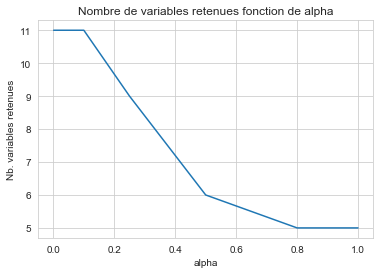

In [24]:
sns.set_style("whitegrid")
ax = plt.gca()

ax.plot(alpha_for_path, nb_non_zero)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Nb. variables retenues')
plt.title("Nombre de variables retenues fonction de alpha")

On calcule l'erreur quadratique moyenne (notée MSE) pour les régressions avec différentes valeurs de $\alpha$, sur l'échantillon d'apprentissage et sur l'échantillon de test.

In [46]:
mse_train=[]
mse_test=[]
lasso = Lasso(max_iter=10000)
for a in my_alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)
    mse_test.append(mean_squared_error(y_test, pred))
    pred_train = lasso.predict(X_train)
    mse_train.append(mean_squared_error(y_train, pred_train))

Text(0.5, 1.0, "MSE de l'échantillon d'apprentissage fonction de alpha")

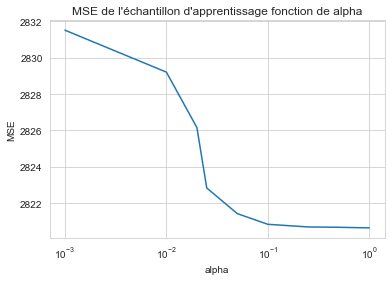

In [47]:
sns.set_style("whitegrid")
ax = plt.gca()

ax.plot(alpha_for_path, mse_train)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title("MSE de l'échantillon d'apprentissage fonction de alpha")

Text(0.5, 1.0, "MSE de l'échantillon de test fonction de alpha")

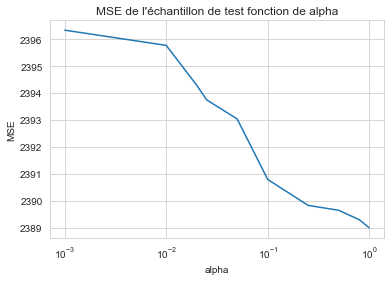

In [48]:
sns.set_style("whitegrid")
ax = plt.gca()

ax.plot(alpha_for_path, mse_test)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title("MSE de l'échantillon de test fonction de alpha")

## 3) Détermination de la valeur de $\alpha$ optimal

Afin de trouver la valeur optimale d'alpha, nous utilisons le package `scikit` et LassoCV qui déterminent un modèle linéaire Lasso avec ajustement itératif le long d'un chemin de régularisation. Le meilleur modèle est sélectionné par validation croisée.

On réalise une validation croisée en 5 blocs.

In [27]:
model = LassoCV(cv=5, random_state=0, max_iter=10000)
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [33]:
print("La meilleure valeur de pénanlisation pour alpha avec validation croisée est", round(model.alpha_,4))

La meilleure valeur de pénanlisation pour alpha avec validation croisée est 0.221


Traçons, pour chaque groupe de validation, l'erreur quadratique moyenne en fonction de la valeur de $\alpha$.

(0.05891441386030578,
 117.5497097839483,
 1753.8075217257128,
 14463.008618768756)

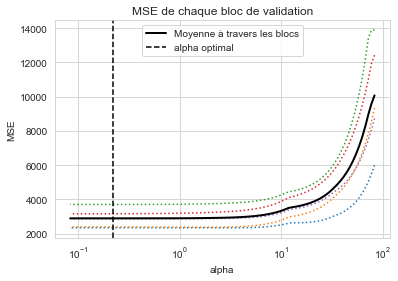

In [49]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Moyenne à travers les blocs",
    linewidth=2,
)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha optimal"
)

plt.legend()
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE de chaque bloc de validation")
plt.axis("tight")

On remarque que la valeur de $\alpha$ optimal 0.221 permet de minimiser l'erreur quadratique moyenne.

On utilise la meilleure valeure de $\alpha$ trouvée pour notre modèle final.

In [34]:
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.221036495089735)

In [35]:
features_selec2 = df2.select_dtypes(include=np.number).drop("Valeur", axis = 1).columns[np.abs(lasso_best.coef_)>0].tolist()
print('Les variables retenues par la régression Lasso sont :', ','.join(features_selec2))

Les variables retenues par la régression Lasso sont : Age,Taille,Salaire,Score total,Technique,Mouvement,Puissance,Defense,Gardien


On remarque que cette fois, la variable *Etat d'esprit* n'a pas été retenu.

Evaluation du modèle avec ce alpha optimal :

In [36]:
print("Le R² de l'échantillon d'apprentissage est", round(lasso_best.score(X_train, y_train),4))
print("Le R² de l'échantillon de test est", round(lasso_best.score(X_test, y_test),4))

Le R² de l'échantillon d'apprentissage est 0.7269
Le R² de l'échantillon de test est 0.7234


On obtient approximativement les mêmes valeurs de R² qu'avec un $\alpha$ = 0.1

In [37]:
pred_train = lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print("L'erreur quadrataique moyenne sur l'échantillon d'apprentissage est",round(mse_train, 2))

pred = lasso_best.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print("L'erreur quadrataique moyenne sur l'échantillon de test est",round(mse_test, 2))


L'erreur quadrataique moyenne sur l'échantillon d'apprentissage est 2822.58
L'erreur quadrataique moyenne sur l'échantillon de test est 2393.84


De même, l'erreur quadratique est sensiblement la même qu'avec $\alpha$ = 0.1